In [22]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, f1_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [47]:
train = pd.read_csv('data/train_clean.csv')
test = pd.read_csv('data/test_clean.csv')
gender_submission = pd.read_csv('data/gender_submission.csv')
test = pd.merge(test, gender_submission, on='PassengerId')
print(train.columns)
print(test.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'Fare',
       'Embarked_Cherbourg', 'Embarked_Queenstown', 'Embarked_Southampton',
       'Alone', 'Large', 'Medium', 'Small', 'Female', 'Male'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Age', 'Fare', 'Embarked_Cherbourg',
       'Embarked_Queenstown', 'Embarked_Southampton', 'Alone', 'Large',
       'Medium', 'Small', 'Female', 'Male', 'Survived_x', 'Survived_y'],
      dtype='object')


In [48]:
X_train = train[['PassengerId', 'Pclass', 'Age', 'Fare',
       'Embarked_Cherbourg', 'Embarked_Queenstown', 'Embarked_Southampton',
       'Alone', 'Large', 'Medium', 'Small', 'Female', 'Male']]
y_train = train['Survived']

In [5]:
X_test = test[['PassengerId', 'Pclass', 'Age', 'Fare',
       'Embarked_Cherbourg', 'Embarked_Queenstown', 'Embarked_Southampton',
       'Alone', 'Large', 'Medium', 'Small', 'Female', 'Male']]
y_test = test['Survived']

# Random Forest

In [34]:
# Definir el modelo de RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Definir la cuadrícula de parámetros
param_grid = {
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8, 16],
}

# Crear el modelo de GridSearchCV con precision como scoring metric
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='precision', n_jobs=-1)

# Ajustar el modelo a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Imprimir los mejores parámetros encontrados
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 100}


In [55]:
# Predecir los datos de prueba usando el mejor modelo encontrado por GridSearchCV
y_pred_rf = grid_search.best_estimator_.predict(X_test)
y_test_rf_train = grid_search.best_estimator_.predict(X_train)
print(precision_score(y_train, y_test_rf_train))
# test['random forest prediction'] = y_pred_rf
# test['Survived'] = y_test['Survived']

0.89419795221843


Accuracy: 0.83453237
Precision: 0.79432624
Confusion Matrix:
[[236  29]
 [ 40 112]]


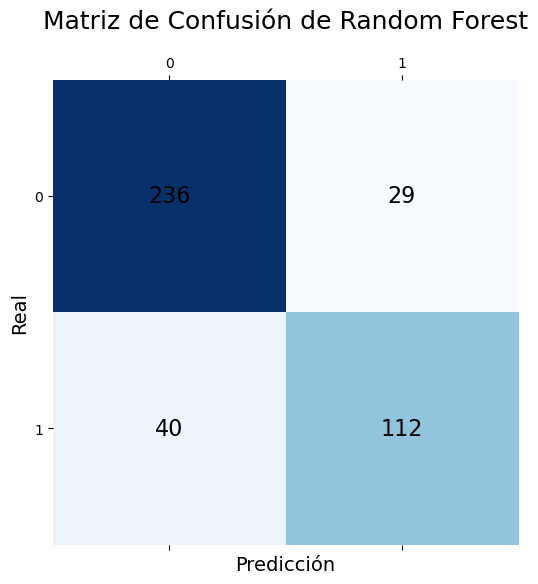

In [36]:
# Evaluar el rendimiento del modelo
accuracy = grid_search.score(X_test, y_test)
print(f'Accuracy: {accuracy:.8f}')

# Evaluar la precision
precision = precision_score(y_test, y_pred_rf)
print(f'Precision: {precision:.8f}')

# Mostrar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_rf)
print('Confusion Matrix:')
print(conf_matrix)
# Graficar la matriz de confusión con matshow
plt.figure(figsize=(8, 6))
plt.matshow(conf_matrix, cmap='Blues', fignum=1)  # Utilizar fignum=1 para evitar la creación de una nueva figura
plt.title('Matriz de Confusión de Random Forest', pad=20, fontsize=18)
plt.xlabel('Predicción', fontsize=14)
plt.ylabel('Real', fontsize=14)

# Agregar las anotaciones de los valores en la matriz
for (i, j), val in np.ndenumerate(conf_matrix):
    plt.text(j, i, f'{val}', ha='center', va='center', fontsize=16, color="black")

# Remover la barra de color
plt.gca().set_frame_on(False)  # Remueve el borde alrededor de la matriz

plt.show()

# Red neuronal feed forward

In [37]:
# Función para calcular la Precision
def precision_metric(y_true, y_pred):
    y_pred_binary = np.where(y_pred > 0.5, 1, 0)  # Convertir las probabilidades en 0 o 1
    return precision_score(y_true, y_pred_binary)

def f1_metric(y_true, y_pred):
    y_pred_binary = np.where(y_pred > 0.5, 1, 0)  # Convertir las probabilidades en 0 o 1
    return f1_score(y_true, y_pred_binary)

# Modificar la función para crear el modelo
def create_model(dropout_rate=0.0, learning_rate=0.001, optimizer='adam'):
    model = Sequential()
    model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(16, activation='relu'))
    if dropout_rate > 0.0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['precision'])  # Mantiene 'accuracy' para monitorear, pero la métrica personalizada es la que usaremos para el score
    return model

# Definir los hiperparámetros a explorar
param_grid = {
    'dropout_rate': [0.0, 0.2],
    'learning_rate': [0.001, 0.01],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [20, 50],
    'epochs': [50,100],
    'patience': [5, 10]  # Añadimos el hiperparámetro 'patience' para EarlyStopping
}

# Realizar la búsqueda manual de hiperparámetros
best_score = -np.inf
best_params = {}

for dropout_rate in param_grid['dropout_rate']:
    for learning_rate in param_grid['learning_rate']:
        for optimizer in param_grid['optimizer']:
            for batch_size in param_grid['batch_size']:
                for epochs in param_grid['epochs']:
                    for patience in param_grid['patience']:  # Iteramos sobre el nuevo hiperparámetro 'patience'
                        
                        model = create_model(dropout_rate=dropout_rate,
                                             learning_rate=learning_rate,
                                             optimizer=optimizer)
                        
                        # Definir el EarlyStopping
                        early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
                        
                        # Entrenar el modelo con EarlyStopping
                        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, 
                                  validation_split=0.2, callbacks=[early_stopping])
                        
                        # Predecir valores
                        y_pred = model.predict(X_test, verbose=0)
                        
                        # Calcular la Precision
                        score = f1_metric(y_test, y_pred)
                        
                        if score > best_score:
                            best_score = score
                            best_params = {
                                'dropout_rate': dropout_rate,
                                'learning_rate': learning_rate,
                                'optimizer': optimizer,
                                'batch_size': batch_size,
                                'epochs': epochs,
                                'patience': patience  # Guardamos el mejor 'patience'
                            }

print(f"Mejor F1 Score: {best_score}")
print(f"Mejores hiperparámetros: {best_params}")

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Mejor F1 Score: 0.8658536585365854
Mejores hiperparámetros: {'dropout_rate': 0.0, 'learning_rate': 0.01, 'optimizer': 'adam', 'batch_size': 50, 'epochs': 50, 'patience': 10}


In [42]:
# Entrenar el mejor modelo encontrado
best_model = create_model(dropout_rate=best_params['dropout_rate'],
                          learning_rate=best_params['learning_rate'],
                          optimizer=best_params['optimizer'])

# Definir el EarlyStopping con el mejor 'patience' encontrado
early_stopping = EarlyStopping(monitor='val_loss', patience=best_params['patience'], restore_best_weights=True)

# Entrenar el modelo con EarlyStopping
best_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], 
               validation_split=0.2, callbacks=[early_stopping], verbose=1)


Epoch 1/50


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 313ms/step - loss: 3.0604 - precision: 0.5130 - val_loss: 1.9600 - val_precision: 0.3539
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.9114 - precision: 0.4323 - val_loss: 0.9541 - val_precision: 1.0000
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.6848 - precision: 0.5362 - val_loss: 0.9755 - val_precision: 0.3580
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.6655 - precision: 0.5183 - val_loss: 0.5400 - val_precision: 0.7200
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5938 - precision: 0.6670 - val_loss: 0.6896 - val_precision: 0.4758
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6404 - precision: 0.5659 - val_loss: 0.7498 - val_precision: 0.4189
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.8084 - precision: 0.5067 - val_loss: 0.6362 - val_precision: 0.7000
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7241 - precision: 0.5290 - val_loss: 0.5451 - 

Accuracy en el conjunto de validación: 0.4352124035358429
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Precision: 0.77099237
[[235  30]
 [ 51 101]]


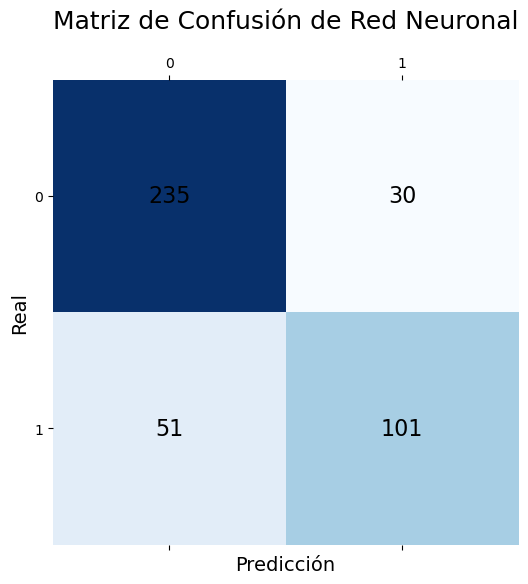

In [43]:
# Evaluar en el conjunto de validación
accuracy = best_model.evaluate(X_test, y_test, verbose=0)[0]
#accuracy1 = accuracy_score(y_test, y_pred)
print(f"Accuracy en el conjunto de validación: {accuracy}")
#print(f"Accuracy1 en el conjunto de validación: {accuracy1}")

# Generar predicciones en el conjunto de prueba
y_pred_probs = best_model.predict(X_test)
y_pred = np.where(y_pred_probs > 0.5, 1, 0)  # Convertir probabilidades en predicciones binarias

precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.8f}')

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
# Graficar la matriz de confusión
# Graficar la matriz de confusión con matshow
plt.figure(figsize=(8, 6))
plt.matshow(conf_matrix, cmap='Blues', fignum=1)  # Utilizar fignum=1 para evitar la creación de una nueva figura
plt.title('Matriz de Confusión de Red Neuronal', pad=20, fontsize=18)
plt.xlabel('Predicción', fontsize=14)
plt.ylabel('Real', fontsize=14)

# Agregar las anotaciones de los valores en la matriz
for (i, j), val in np.ndenumerate(conf_matrix):
    plt.text(j, i, f'{val}', ha='center', va='center', fontsize=16, color="black")

# Remover la barra de color
plt.gca().set_frame_on(False)  # Remueve el borde alrededor de la matriz

plt.show()

In [52]:
y_pred_train = best_model.predict(X_train)
y_pred_train = np.where(y_pred_train > 0.5, 1, 0)  # Convertir probabilidades en predicciones binarias

print(precision_score(y_train, y_pred_train))

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
0.765079365079365
